In [1]:
# mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector, Dropout, Bidirectional, Input, dot, Activation, TimeDistributed, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras 
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import nltk
import io
from nltk.tokenize.toktok import ToktokTokenizer
import unicodedata
from sklearn.model_selection import train_test_split

# plot japanese lang
!pip install japanize-matplotlib
import japanize_matplotlib
!pip install keras-multi-head
from keras_multi_head import MultiHead
# ignore warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

     |████████████████████████████████| 4.1MB 3.3MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.0.5-cp36-none-any.whl size=4118721 sha256=5a50229687d53e8d91a6a9656ada0ca0f278583fc0a669775873678915553034
  Stored in directory: /root/.cache/pip/wheels/6c/8a/08/4a784957da9f3c2b4839b4986be2fba2a481877318948be52c
Successfully built japanize-matplotlib
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=7886e366c2f60647c60049446715704babfa99d1110cd34ebd05d080224ddf18
  Stored in directory: /root/.cache/pip/wheels/bb/df/3f/81b36f41b66e6a9cd69224c70a737de2bb6b2f7feb3272c25e
  Created wheel for keras-self-attention: filename=keras_self_attention-0.41.0-cp36-none-any.whl size=17290 sha256=652173e5b672179a02987975cc35f3a702ad04a164c4c90f76250c1f6c680e6b
  Stored in directory: /root/.cache/pip/wheels/cc/dc/17/84258b27a04cd38ac91998abe148203720ca696186635db694
Successfully built keras-multi-head keras-self-attenti

Using TensorFlow backend.


# load text file

**this dataset is aleady implemented a SentenceSpace**

In [0]:
num_example = 50000

# create each languages list
def create_lang_list(num_example):
    # load txt file
    lines =  io.open("/content/drive/My Drive/Colab Notebooks/raw.txt", encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[w for w in l.split('\t')]  for l in lines[:num_example]]

    return zip(*word_pairs)

In [0]:
en, ja = create_lang_list(num_example)

In [0]:
# use other dataset
en = io.open("/content/drive/My Drive/OpenSubtitles2016.en-ja.en", encoding="utf-8").read().strip().split("\n")
ja = io.open("/content/drive/My Drive/OpenSubtitles2016.en-ja.ja", encoding="utf-8").read().strip().split("\n")
en = en[:30000]
ja = ja[:30000]

In [4]:
# sentencepiece
!pip install sentencepiece
import sentencepiece as spm
spm_model = spm.SentencePieceProcessor()
spm_model. load("/content/drive/My Drive/wiki-ja.model")

     |████████████████████████████████| 1.0MB 1.2MB/s 


True

In [0]:
  ja = [" ".join(spm_model.encode_as_pieces(i)).replace("▁", "") for i in ja]

# Text Pre-processing

**Removing accented characters** 

e.g. é → e.

**Expanding Contractions** 

e.g. don't → do not, I'd → I would

**remove special word** 

e.g. remove "123#@"

**Stemming**

 e.g. corder, codes → code

**Lemmatization**

 e.g. better → good

**Tokenize**

 e.g. I am going to restaurant → [[I], [am], [going], [to], [restaurant]]

# Removing accented characters

English might have accent like é but Japanese doesn't have any accent I just create different function to ascii for Japanese and English

In [0]:
# Removing accented characters
def english_unicode_to_ascii(text):
     return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore'))

def japanese_unicode_to_ascii(text):
    return ''.join(ascii_text for ascii_text in unicodedata.normalize('NFKD', text))

In [0]:
# e.g.
japanese_unicode_to_ascii("こんにちは。今日は"), english_unicode_to_ascii("Hello world é ")

# Expanding Contractions
Japanese doesn't have a Contraction words so I just create a one function to expand Contractions for Engish

In [0]:
def expand_constraction(text):

    #  dic for expand constraction words
    constraction_dict= {
        "ain't": "is not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    #  define match pattern
    #  IGNORECASE → no matter if word is lowercase or uppercase
    #  DOTAIL → . is going to match \n
    contraction_pattern = re.compile('({})'.format('|'.join(constraction_dict.keys())),
                                                  flags=re.IGNORECASE | re.DOTALL)
    #  expand words
    def expand_match(constraction):
        # get constraction word
        match = constraction.group(0)
        first_char = match[0]
        #  get expand word from constraction dict
        expand_constraction = constraction_dict.get(match)\
                                                    if constraction_dict.get(match) \
                                                    else constraction_dict.get(match.lower())
        
        # create expand constraction
        expand_constraction = first_char + expand_constraction[1:]
        return expand_constraction
    
    expanded_text = contraction_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [8]:
# e.g.
expand_constraction("you're good I'd like to go he's she's")

'you are good I would like to go he is she is'

# remove special characters and create space between word and punctuation

replacing everything with space except(a-z, A-Z, "?", "!", "-", "ー", "Kanji", "Katakana", "Hiragana") 
create space between word and punctuation (? ! )

In [0]:
def replace_special_character_to_space(text):
    pattern = r"[^a-zA-Z\u3041-\u309F\u30A1-\u30FF\uFF66-\uFF9F\u4E00-\u9FD0\u309B\u3099\uFF9E\u309C\u309A\uFF9F?!\-/\s]+"
    text = re.sub(pattern, '', text).rstrip().strip()
    text = text.replace("・" , "")

    text = re.sub(r"([?!.,。、])", r" \1 ", text)
    text = text.lower()

    return text

In [10]:
# e.g.
replace_special_character_to_space("hello, . #@…123world."), replace_special_character_to_space("こん・にちは。・ いい天気。")

('hello  world', 'こんにちは いい天気')

# Stemming and Lemmatization
I will do stemming only english which can create a base form of a word from a given word. Japanese language doesn't need a stemming

In [0]:
def stemmer_word(text):
    ps = nltk.stem.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [12]:
# e.g.
stemmer_word("hello world she has cat but he had dogs he is went to traveling")

'hello world she ha cat but he had dog he is went to travel'

# Normalize each word

In [0]:
def normalize_english(english_text, japanese_text):
    
    input_value = ()
    target_value = ()
    
    for en_text, ja_text in zip(english_text, japanese_text):
        
        # normalize English
        en_text = english_unicode_to_ascii(en_text)
        en_text = expand_constraction(en_text)
        en_text = replace_special_character_to_space(en_text)
         
        input_value += (en_text, )

        # normalize Japanese
        ja_text = japanese_unicode_to_ascii(ja_text)
        ja_text = expand_constraction(ja_text)
        ja_text = replace_special_character_to_space(ja_text)

        ja_text = "START_ " + ja_text + " _END"
        
        target_value += (ja_text, )

    return input_value, target_value

# get clean text data

In [0]:
input_value, target_value = normalize_english(en, ja)
x = pd.Series(input_value) 
y = pd.Series(target_value)

In [15]:
all_eng = set()
for inp in x:
  for word in inp.split():
    if word not in all_eng:
      all_eng.add(word)

all_ja = set()
for tar in y:
  for word_ja in tar.split():
    if word_ja not in all_ja:
      all_ja.add(word_ja)


print("unique vocab %d" % len(all_eng))
print("unique vocab %d" %len(all_ja))

unique vocab 12307
unique vocab 11371


In [16]:
input_word = sorted(list(all_eng))
target_word = sorted(list(all_ja))

num_encoder_tokens = len(all_eng)
num_decoder_tokens = len(all_ja)
num_encoder_tokens, num_decoder_tokens

(12307, 11371)

In [17]:
num_decoder_tokens+=1
print(num_decoder_tokens)

11372


In [0]:
input_token_index = dict([ (word, i+1) for i, word in enumerate(input_word)])
target_token_index = dict([ (word, i+1) for i, word in enumerate(target_word)])

In [0]:
reverse_input_char = dict((i, word) for word, i in input_token_index.items())
reverse_target_char = dict((i, word) for word, i in target_token_index.items())

english length: 54
japanese length: 49


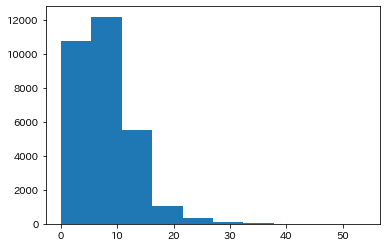

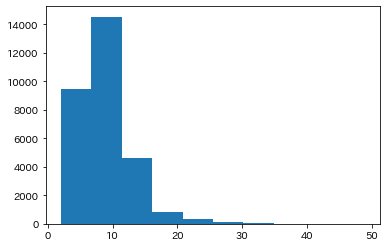

In [20]:
# populate the lists with sentence lengths
english_len = [len(i.split()) for i in x]

japanese_len = [len(i.split()) for i in y]

plt.figure()
plt.hist(english_len)

plt.figure()
plt.hist(japanese_len)

# print max length
print("english length:", max(english_len))
print("japanese length:", max(japanese_len))
max_len_input =  max(english_len)
max_len_target =  max(japanese_len)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3)

In [22]:
X_train.shape

(21000,)

In [0]:
def generate_batch(X = X_train, Y = Y_train, batch_size=128):
  while True:
      assert len(X) == len(Y)
      for i in range(0, len(X), batch_size):
          encoder_input_data = np.zeros((batch_size, max_len_input), dtype="float32")
          decoder_input_data = np.zeros((batch_size, max_len_target), dtype="float32")
          decoder_target_data = np.zeros((batch_size, max_len_target, num_decoder_tokens), dtype="float32")
          for j, (input_text, target_text) in enumerate(zip(X[i:i+batch_size], Y[i:i+batch_size])):
              for t, word in enumerate(input_text.split()):
                  encoder_input_data[j, t] = input_token_index[word]
        
              for t, word in enumerate(target_text.split()):
                  if t < len(target_text.split())-1:
                      decoder_input_data[j, t] = target_token_index[word]
          
                  if t > 0:
                      decoder_target_data[j, t-1, target_token_index[word]] = 1.
          yield([encoder_input_data, decoder_input_data], decoder_target_data)


In [0]:
# build NMT model
in_timesteps = max_len_input
out_timesteps = max_len_target
units = 512

# build encoder model
encoder_input = Input(shape=(in_timesteps, ))

# use pre-trained model Word2Vec
encoder_embedding = Embedding(input_dim=num_encoder_tokens+1, output_dim=units, mask_zero=True)(encoder_input) 
# Dropout
encoder_embedding = Dropout(0.2)(encoder_embedding)

encoder_output, state_h, state_c = LSTM(units, return_sequences=True, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]
test_encoder_state = [encoder_output, state_h, state_c ]

# build decoder model
decoder_input = Input(shape=(out_timesteps, ))

# use pre-trained model Word2Vec
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=units, mask_zero=True)
decoder_emb = decoder_embedding(decoder_input)

# Dropout
decoder = Dropout(0.2)(decoder_emb)

decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder, _, _ = decoder_lstm(decoder,  initial_state=encoder_states)


t = Dense(5000, activation='tanh')(decoder)
t2 = Dense(5000, activation='tanh')(encoder_output)
attention = dot([t, t2], axes=[2, 2])

attention = Dense(in_timesteps, activation='tanh')(attention)
attention = Activation('softmax')(attention)

context = dot([attention, encoder_output], axes = [2,1])

decoder_combined_context = tensorflow.keras.layers.concatenate([context, decoder])

decoder_combined_context=Dense(2000, activation='tanh')(decoder_combined_context)
output=(Dense(num_decoder_tokens, activation="softmax"))(decoder_combined_context)

model = Model(inputs=[encoder_input, decoder_input], outputs=[output])

In [0]:
gen_train = generate_batch(X_train, Y_train, 128)
gen_val = generate_batch(X_test, Y_test, 128)

In [36]:
from math import ceil
trian_step = ceil(len(X_train) / 128 )
val_step = ceil(len(X_test) / 128)
val_step

71

In [0]:
def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [37]:
adam = optimizers.Adam(lr=0.0001, decay=1e-2)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', precision])
model.summary()
# checkpoint
filename = 'model.h1.22_Nov_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='min')              

# train model
history = model.fit_generator(gen_train, validation_data=gen_val , steps_per_epoch=trian_step, validation_steps=val_step, epochs=5, callbacks=[checkpoint], verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 49)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 54, 512)      6301696     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 49, 512)      5822464     input_6[0][0]                    
____________________________________________________________________________________________

In [38]:
# define encoder model
encoder_model = Model(encoder_input, test_encoder_state)
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 54)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 54, 512)           6301696   
_________________________________________________________________
dropout_4 (Dropout)          (None, 54, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                [(None, 54, 512), (None,  2099200   
Total params: 8,400,896
Trainable params: 8,400,896
Non-trainable params: 0
_________________________________________________________________


In [0]:
def define_decoder(encoder_out):
    # define decoder architecuture
    decoder_state_h = Input(shape=(units, ))
    decoder_state_c = Input(shape=(units, ))
    decoder_state = [decoder_state_h, decoder_state_c]

    # decoder embedding
    dec_emb2 = decoder_embedding(decoder_input)
    decoder2 = Dropout(0.1)(dec_emb2)

    decoder_output, state_h2, state_c2 = decoder_lstm(decoder2, initial_state=decoder_state)

    decoder_states2 = [state_h2, state_c2]

    # t = Dense(5000, activation='tanh')(decoder_output)
    # t2 = Dense(5000, activation='tanh')(encoder_out)
    # attention = dot([t, t2], axes=[2, 2])

    # attention = Dense(in_timesteps, activation='tanh')(attention)
    # attention = Activation('softmax')(attention)

    # context = dot([attention, encoder_out], axes = [2,1])

    # decoder_combined_context = keras.layers.concatenate([context, decoder_output])

    # decoder_combined_context=Dense(2000, activation='tanh')(decoder_combined_context)

    decoder_output = (Dense(num_decoder_tokens, activation="softmax"))(decoder_output)

    decoder_model = Model([decoder_input] + decoder_state, [decoder_output] + decoder_states2)

    return decoder_model

In [0]:
def decoder_seq(input_seq):
    # encoder the input seq as vector
    output_en, a, b = encoder_model.predict(input_seq)
    enc_output = encoder_model.layers[3].output[0]
    en_state = [a, b]
    # generate empty target sequence
    target_seq = np.zeros((1, 49))
    # populate the first character of target seq
    target_seq[0, 0] = target_token_index["START_"]

    # loop for batch of sequences
    stop_condition = False
    decoder_sentence = ''
    decoder_model = define_decoder(enc_output)

    while not stop_condition:
        output_token, h, c = decoder_model.predict([target_seq] + en_state)

        sampled_token_index = np.argmax(output_token[0, -1, :])
        sampled_char = reverse_target_char[sampled_token_index]
        decoder_sentence += ' ' + sampled_char


        # stop condition
        if sampled_char == "_END" or len(decoder_sentence) > 49:
          stop_condition = True
        

        # update the target sequence
        target_seq = np.zeros((1, 49))
        target_seq[0, 0] = sampled_token_index

        # update states
        en_state = [h, c]
    
    return decoder_sentence

In [0]:
train_gen = generate_batch(X_train, Y_train, 1)
k = -1

In [68]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoder_sentence = decoder_seq(input_seq)
print("input english %s" % X_train[k:k+1].values[0])
print("actual %s" % Y_train[k:k+1].values[0][6:-4])
print("predict %s" % decoder_sentence[:-4] )

input english i was tryin to stabilise below the belt when this guy the size of the statue of liberty walks up to me
actual  下 を な だ めて た 時に  自由 の 女神 のような  デ カ 物 が やってきた 
predict  戦闘機 が変わる が変わる ヘルメット ヘルメット ヘルメット ヘルメット ヘルメット ヘ


In [0]:
from nltk.translate.bleu_score import corpus_bleu

# calculate BLEU score
print('BLEU corpus: %f' % corpus_bleu(actual, predicted))
# from nltk.translate.bleu_score import sentence_bleu
# print("BLUE  sentense: %f" % sentence_bleu(actual, predicted))